In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import quad
import sympy as sym
sym.init_printing()

$$ \begin{bmatrix}\frac{1}{\Delta y^2}+mL^2V_1 & -\frac{1}{2 \Delta y^2} &   0 & 0...\\ -\frac{1}{2 \Delta y^2} & \frac{1}{\Delta y^2}+mL^2V_2 & -\frac{1}{2 \Delta y^2} & 0... \\ ...& ... & ... & -\frac{1}{2 \Delta y^2}\\...0 & 0 & -\frac{1}{2 \Delta y^2} & \frac{1}{\Delta y^2}+mL^2V_{N-1} \\ \end{bmatrix} \begin{bmatrix} \psi_1 \\ \psi_2 \\ ... \\ \psi_{N-1} \end{bmatrix} = mL^2 E \begin{bmatrix} \psi_1 \\ \psi_2 \\ ... \\ \psi_{N-1} \end{bmatrix} $$

$$ \psi_0 = \psi_N = 0$$

Define what $N$ and $dy$ is

In [2]:
N = 100
dy = 1/N
y = np.linspace(0, 1, N+1)

Define potential $mL^2 V$

In [3]:
#np.where(((y<0.25) | (y>0.75)), 1e8, 0)

In [4]:
def mL2V(y):
    #return 1000*np.sin(20*y) * y**4 
    return np.where(((y<0.25) | (y>0.75)), 500, 0)

In [5]:
d = 1/dy**2 + mL2V(y)[1:-1]
e = -1/(2*dy**2) * np.ones(len(d)-1)

In [6]:
w, v = eigh_tridiagonal(d, e)

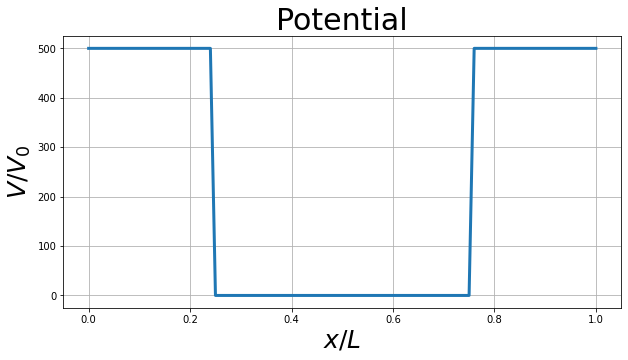

In [7]:
plt.figure(figsize=(10,5))
plt.plot(y, mL2V(y), lw=3)
plt.title('Potential', fontsize=30)
plt.ylabel('$V/V_0$', fontsize=25)
plt.xlabel('$x/L$', fontsize=25)
plt.grid()
#plt.savefig('v3p1.png', dpi=200)

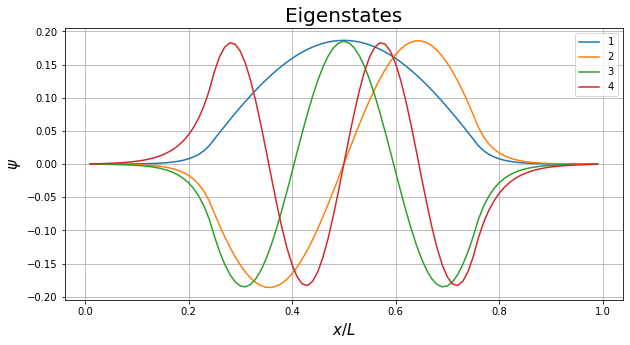

In [8]:
plt.figure(figsize=(10,5))
plt.plot(y[1:-1], v.T[0], label="1")
plt.plot(y[1:-1], v.T[1], label="2")
plt.plot(y[1:-1], v.T[2], label="3")
plt.plot(y[1:-1], v.T[3], label="4")
plt.title('Eigenstates', fontsize=20)
plt.ylabel('$\psi$', fontsize=15)
plt.xlabel('$x/L$', fontsize=15)
plt.grid()
plt.legend()
plt.savefig('v3p2.png', dpi=200)



Text(0, 0.5, '$mL^2 E/\\hbar^2$')

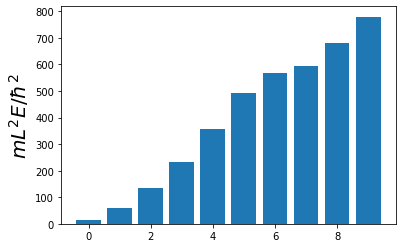

In [9]:
plt.bar(np.arange(0, 10, 1), w[0:10])
plt.ylabel('$mL^2 E/\hbar^2$', fontsize=20)

### Solving Semi-analytically for Solutions ###

We are assuming the solutions to the finite square well look like sinusoids in the well and decaying exponentials outside of it.  That means we are looking for solutions of the form $ e^{-\alpha x} $ outside the well and of the form $ sin(k x) $  or $ cos(k x) $, but not a superposition of both due to potential symmetry, within the well.

By setting $ y = \alpha L/2 $ and $ x = k L / 2 $ we arrive at two solutions which can be solved simultaenously:

$ y = x tan (x) $ and $ x^2 + y^2 = R^2_0 $ where $ R^2_0 = \frac{2 m L^2 V_0}{4 \hbar } $

In [10]:
from sympy import Matrix, exp, sin, cos, integrate, oo, Eq, Rational, lambdify



In [11]:
alpha, L, k, E, hbar, V0, V, m = sym.symbols("alpha L k E hbar V_0 V m", real=True, positive=True)
alpha, L, k, E, hbar, V0, V, m

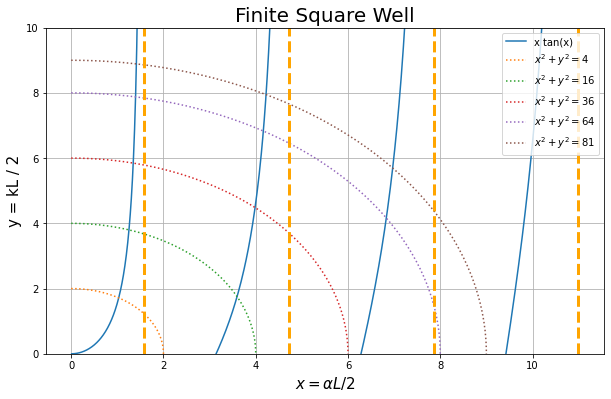

In [12]:
fig = plt.figure(figsize=(10,6))

plt.title('Finite Square Well', fontsize=20)
plt.ylim(0, 10)


line_color = None
piranges = [(0, np.pi/2), (np.pi/2, 3*np.pi/2), (3*np.pi/2, 5*np.pi/2),  (5*np.pi/2, 7*np.pi/2), ]
for xlow, xhi in piranges:
    x = np.linspace(xlow+0.01, xhi-.01, 200)
    y = x*np.tan(x)
    if not line_color:
        lines = plt.plot(x,y, label='x tan(x)')
        line_color = lines[-1].get_color()
    else:
        plt.plot(x,y, color=line_color)


plt.ylabel('y = kL / 2', fontsize=15)
plt.xlabel('$ x = \\alpha L/2$', fontsize=15)
plt.grid()
#xmin, xmax, ymin, ymax = plt.axis()

# Plot the circles
theta = np.linspace(0, np.pi, 100)
for r in (2,4,6,8,9):
    xc = r * np.sin(theta)
    yc = r * np.cos(theta)
    plt.plot(xc,yc, label="$x^2 + y^2={}$".format(r*r), linestyle='dotted')

# Plot the asymptotes
ymin, ymax = plt.gca().get_ylim()
xvlines = ( [avline[1] for avline in piranges])
plt.vlines(xvlines, ymin, ymax, linestyle='dashed', color='orange', lw=3)
plt.legend()



It was kind of tricky to work out how many roots I would expect to find and whereabouts I would expect to find them.  This is kind of important if we want to bracket the roots in a root finding algorithm.

In [13]:
def fn(r):
    n  = int(r/np.pi)+1
    print("Expect to find {} roots".format(n))
    for i in range(0,n):
        print ("Root {} between {} and {}".format(i+1, i*np.pi, (i+0.5)*np.pi))

In [14]:
fn(4)

Expect to find 2 roots
Root 1 between 0.0 and 1.5707963267948966
Root 2 between 3.141592653589793 and 4.71238898038469


We are looking for some piecewise solutions to Schrödinger's equation.

$$ \left [ \frac{- \hbar^2}{2m} \frac{\partial}{\partial x^2} + V(x,t) \right ] \Psi (x,t) = E \, \Psi (x,t)  $$

If we multiply through by $ -\frac{2m}{\hbar^2} $ and do some rearranging we end up with:

$$  \frac{\partial  \Psi (x,t) }{\partial x^2}  + \frac{2m}{\hbar^2} (E - V ) \, \Psi (x,t)  = 0  $$

If $ E \gt V $ then the solutions must be a decaying exponential.  If $ E \lt V $ then the solutions will be sinusoids of various frequencies.

The intersectons of the circles and the graphs determine the fixed energies where:

$$ k^2 = \frac{2mE}{\hbar^2} \mbox{ and } \alpha^2 =  \frac{2m(V_0 - E)}{\hbar^2} $$

and the square of the radius is proportional the to the depth of the finite potential:

$$ R^2 = k^2 + \alpha^2 =  \left( \frac{2 m V_0}{\hbar^2} \right) $$



In [15]:
alpha, L, k, E, hbar, V0, x, A, m = sym.symbols("alpha L k E hbar V_0 x A m", real=True, positive=True)
alpha, L, k, E, hbar, V0, x, A, m

Now we want to set up a joining of the two wavefunctions $ e^{-\alpha x} $ and $ \cos(kx) $ at the point x = L/2 to be continuous and also we want its derivatives joined be continuous also.

Therefore:

$$ e^{-\alpha x} = \cos(kx) $$

and it's derivative is:

$$ -\alpha e^{-\alpha x} = -k \sin (kx) $$

If we substitute one of the join points x = L/2 we get

$$ e^{-\frac{\alpha L}{2}} = \cos \left( \frac{k L}{2} \right) $$

If we agree to set L = 2 then this simplifies to


$$ e^{- \alpha} = \cos \left( k \right) $$

and

$$  -\alpha e^{-\alpha } = -k \sin (k)  $$

In [16]:
m1 = sym.Matrix([[exp(-alpha), -cos(k)],[-alpha*exp(-alpha), k*sin(k)]])
m1

⎡  -α            ⎤
⎢ ℯ      -cos(k) ⎥
⎢                ⎥
⎢    -α          ⎥
⎣-α⋅ℯ    k⋅sin(k)⎦

In [17]:
m1.det()

In [18]:
mdet = sym.simplify(m1.det()/(sym.exp(-alpha)))
sym.Eq(mdet, 0)

In [19]:
mdet.subs(alpha, k*sym.tan(k))

In [20]:
sym.simplify(_)

In [21]:
slice = m1[0,:]*alpha
m1[0,:] = slice
m1

⎡   -α            ⎤
⎢α⋅ℯ     -α⋅cos(k)⎥
⎢                 ⎥
⎢    -α           ⎥
⎣-α⋅ℯ    k⋅sin(k) ⎦

In [22]:
row = m1[1,:] + sym.Matrix(slice)
row

[0  -α⋅cos(k) + k⋅sin(k)]

In [23]:
m1[1,:] = row
m1

⎡   -α                      ⎤
⎢α⋅ℯ         -α⋅cos(k)      ⎥
⎢                           ⎥
⎣  0    -α⋅cos(k) + k⋅sin(k)⎦

However $ \displaystyle \alpha \cos{\left(k \right)} - k \sin{\left(k \right )} = 0 $ so that value ought to be replaced by zero in the matrix also.

In [24]:
m1[1,1]=0
m1

⎡   -α           ⎤
⎢α⋅ℯ    -α⋅cos(k)⎥
⎢                ⎥
⎣  0        0    ⎦

This means $  \begin{pmatrix}e^{-\alpha} & -\cos(k)\\ 0 & 0 \end{pmatrix}  \begin{pmatrix}A\\B\end{pmatrix} =  \begin{pmatrix}0\\0\end{pmatrix}  $ or that $ A e^{- \alpha} -B \cos(k) = 0 $

Therefore we can write  $ A  = B \cos(k) e^{ \alpha} $ or $ B = A \sec(k) e^{ -\alpha } $ and we can set $ A = 1 $ for the pre normalised value.

Now if assume by the same symmetry argument that half of the wave function probability density function integral must be 0.5 then we should be able to compute both A and B.

In [25]:
m2 = sym.Matrix([[exp(-alpha), -sin(k)],[-alpha*exp(-alpha), -k*cos(k)]])
m2

⎡  -α             ⎤
⎢ ℯ       -sin(k) ⎥
⎢                 ⎥
⎢    -α           ⎥
⎣-α⋅ℯ    -k⋅cos(k)⎦

In [26]:
m2.det()

In [27]:
mdet = sym.simplify(m2.det()/(sym.exp(-alpha)))
sym.Eq(mdet, 0)

### Compute the normalisation constant for cos(kx) ###

In [28]:
f1 = exp(- alpha * x)
f1

In [29]:
f2 = A * cos(k*x)
f2

In [30]:
f3 = A*sin(k*x)
f3

In [31]:
nf1 = integrate(f2**2, (x, 0, 1)) + integrate(f1**2, (x, 1, oo))
nf1

In [32]:
nf2 = integrate(f3**2, (x, 0, 1)) + integrate(f1**2, (x, 1, oo))
nf2

In [33]:
e1 = Eq(nf1, Rational(1,2))
e1

In [34]:
e2 = Eq(nf2, Rational(1,2))
e2

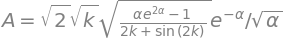

In [35]:
# Compute the normalisation value
normalisation1 = sym.simplify(sym.solveset(e1, A).args[0])
Eq(A, normalisation1)

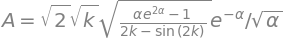

In [36]:
# Compute the normalisation value
normalisation2 = sym.simplify(sym.solveset(e2, A).args[0])
Eq(A, normalisation2)

### Numerical Solution ###

Now to find the solutions for $ \alpha $ and k which we are going to have to solve for numerically.

In [37]:
from scipy.optimize import root_scalar

$$ \alpha^2 + k^2 = R_0^2 $$

and since we know

$$ \alpha = k \tan k $$

then we can substitute that into our first equation to get:

$$ \left( k^2 \tan^2(k) \right) + k^2 = R_0^2 \Rightarrow k^2( 1 + \tan^2(k)) = k^2 \sec^2(k) = R_0^2 $$

In [38]:
def rootfn(x, r0):
    return x**2/np.cos(x)**2-r0**2

In [39]:
x1 = np.linspace(0, np.pi/2, 10)
y1 = rootfn(x1, 1)
print (y1)

[-1.00000000e+00 -9.68591166e-01 -8.62011436e-01 -6.34459096e-01
 -1.69448083e-01  8.43146052e-01  3.38649084e+00  1.17599051e+01
  6.36538288e+01  6.58079015e+32]


In [40]:
rootval = root_scalar(rootfn, args=(2,), method='bisect', bracket=(0, np.pi/2), rtol=0.0001)
rootval

      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 14
           root: 1.0297804776674795

In [41]:
rootfn(rootval.root, 2)

In [42]:
allroots=[]
for r in range(1,10):
    # calculate the number of roots we expect to find for this radius
    n = int(r/np.pi)+1
    roots = []
    for ii in range(n):
        lowrange = ii*np.pi
        hirange = (ii+.5)*np.pi
        try:
            root = root_scalar(rootfn, args=(r,), method='bisect', bracket=(lowrange+0.01, hirange-0.01), x0=lowrange + 0.01, x1=hirange-0.01, rtol=0.0001)
            if not root.converged:
                print("Warning root {} for radius {} did not converge".format(ii+1, r))
            roots.append(root.root)
        except ValueError:
            print (roots)
            print(r, lowrange, hirange)
            raise
    print (r, roots)
    allroots.append((r, roots.copy()))

        

1 [0.7390654728477594]
2 [1.0298871106698615]
3 [1.170162999116519]
4 [1.252321886546815, 3.59513706199805]
5 [1.3064634575262268, 3.837259681867517]
6 [1.344703308357839, 3.9856757365803097]
7 [1.373288543385431, 4.088658305156534, 6.616141671133699]
8 [1.3954373678770082, 4.165138006819758, 6.830436280744518]
9 [1.413042843754929, 4.224201538797298, 6.96825118869211]


r=1, k=0.7391, α=0.6736, AB factor= 0.6899 E=0.5462 hbar^2/2m
r=2, k=1.0299, α=1.7146, AB factor= 0.3497 E=1.0607 hbar^2/2m
r=3, k=1.1702, α=2.7628, AB factor= 0.1618 E=1.3693 hbar^2/2m
r=4, k=1.2523, α=3.7984, AB factor= 0.0716 E=1.5683 hbar^2/2m
r=4, k=3.5951, α=1.7524, AB factor=-0.1929 E=12.9250 hbar^2/2m
r=5, k=1.3065, α=4.8268, AB factor= 0.0307 E=1.7068 hbar^2/2m
r=5, k=3.8373, α=3.2038, AB factor=-0.0529 E=14.7246 hbar^2/2m
r=6, k=1.3447, α=5.8459, AB factor= 0.0129 E=1.8082 hbar^2/2m
r=6, k=3.9857, α=4.4832, AB factor=-0.0170 E=15.8856 hbar^2/2m
r=7, k=1.3733, α=6.8624, AB factor= 0.0053 E=1.8859 hbar^2/2m
r=7, k=4.0887, α=5.6822, AB factor=-0.0058 E=16.7171 hbar^2/2m
r=7, k=6.6161, α=2.2881, AB factor= 0.1074 E=43.7733 hbar^2/2m
r=8, k=1.3954, α=7.8759, AB factor= 0.0022 E=1.9472 hbar^2/2m
r=8, k=4.1651, α=6.8356, AB factor=-0.0021 E=17.3484 hbar^2/2m
r=8, k=6.8304, α=4.1620, AB factor= 0.0182 E=46.6549 hbar^2/2m
r=9, k=1.4130, α=8.8829, AB factor= 0.0009 E=1.9967 hbar^2/2m
r

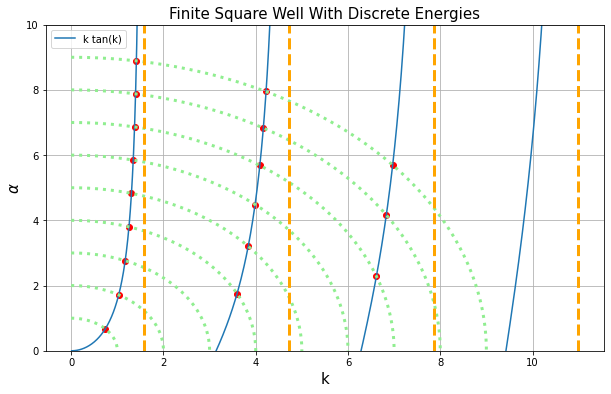

In [43]:
fig = plt.figure(figsize=(10,6))

plt.title('Finite Square Well With Discrete Energies', fontsize=15)
plt.ylim(0, 10)


line_color = None
piranges = [(0, np.pi/2), (np.pi/2, 3*np.pi/2), (3*np.pi/2, 5*np.pi/2),  (5*np.pi/2, 7*np.pi/2), ]
for xlow, xhi in piranges:
    x1 = np.linspace(xlow+0.01, xhi-.01, 200)
    y1 = x1*np.tan(x1)
    if not line_color:
        lines = plt.plot(x1,y1, label='k tan(k)')
        line_color = lines[-1].get_color()
    else:
        plt.plot(x1,y1, color=line_color)


plt.xlabel('k', fontsize=15)
plt.ylabel(r'$ \alpha $', fontsize=15)
plt.grid()
#xmin, xmax, ymin, ymax = plt.axis()

# Plot the circles
theta = np.linspace(0, np.pi, 100)
for r in range(1,10):
    xc = r * np.sin(theta)
    yc = r * np.cos(theta)
    plt.plot(xc,yc, color='lightgreen', linestyle='dotted', lw=3)
    
# Plot the intersections of the circles and the x tan x lines.
scatterx = []
scattery = []
energies = []
for r, roots in allroots:
    for root in roots:
        k1 = root
        alpha1 = k1*np.tan(k1)
        scatterx.append(k1)
        scattery.append(alpha1)
        
        abfactor = np.exp(-alpha1)/np.cos(k1)
        print ("r={}, k={:.4f}, α={:.4f}, AB factor={:7.4f} E={:.4f} hbar^2/2m"\
               .format(r, k1,alpha1, abfactor, k1**2))
        energies.append((r, k1,alpha1, abfactor))
plt.scatter(scatterx, scattery, c='red')

# Plot the asymptotes
ymin, ymax = plt.gca().get_ylim()
xvlines = ( [avline[1] for avline in piranges])
plt.vlines(xvlines, ymin, ymax, linestyle='dashed', color='orange', lw=3)
plt.legend()



In [44]:
def fn(x, alpha, k, abfactor):
    if -1 <= x <= 1:
        return abfactor * np.cos(k*x)
    else:
        return np.exp(-alpha * np.abs(x))


In [45]:
def fn2(x, alpha, k, abfactor):
    return fn(x, alpha, k, abfactor)**2

In [46]:
fnv = np.vectorize(fn)

In [47]:
N = 200

xval = np.linspace(-5, 5, N+1)

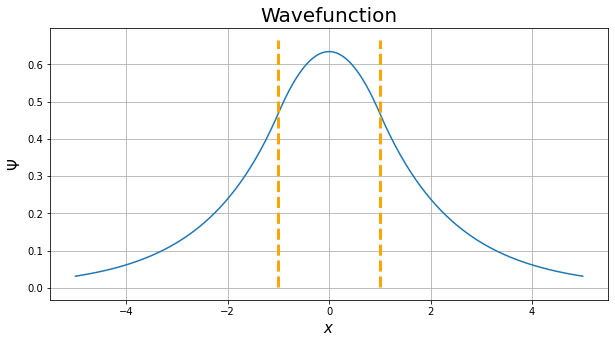

In [48]:
plt.figure(figsize=(10,5))
r, k, alp, abfactor = energies[0]

# Normalise the area under the curve
area = quad(fn2, -np.inf, np.inf, args=(alp, k, abfactor) )
yval = fnv(xval, alp, k, abfactor)/np.sqrt(area[0])
#display(exp(-alpha))
#print (area)


plt.plot(xval,yval)
plt.title('Wavefunction', fontsize=20)
plt.ylabel('$\Psi$', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.grid()

ymin, ymax = plt.gca().get_ylim()
xvlines = [-1, 1]
plt.vlines(xvlines, ymin, ymax, linestyle='dashed', color='orange', lw=3)
#plt.legend()

#plt.savefig('v3p1.png', dpi=200)

In [49]:
from IPython.display import display_latex
display_latex("$ 3x $", raw=True)

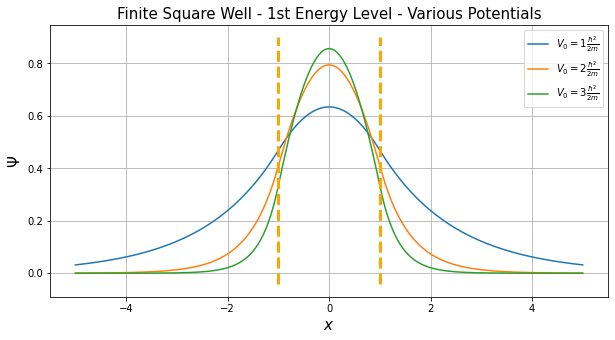

In [50]:
plt.figure(figsize=(10,5))

#s = r"""$ \begin{{ matrix }}{:.4f} e^{{- {:.4f} x}} & \text{{if }} x \leq 1 \\ {:.4f} \sin({:.4f} x) & \text{{if }} x \ge 1  \end{{matrix}} $
s = r"$ v_0 = %d \frac{\hbar^2}{2m} \Rightarrow \Psi = \left \{ \begin{matrix} %.3f \, e^{- %.3f \, x} & \text{if } |x| \lt 1 " + \
    r"\\ %.3f \cos (%.3f x) & \text{if } |x| \ge 1   \end{matrix} \right \} $"
#print (repr(s))
eqns = []

for ii in range(0,3):
    r, k, alp, abfactor = energies[ii]
    area = quad(fn2, -np.inf, np.inf, args=(alp, k, abfactor) )
    #print(r, k, alp)
    #print (area)
    s1 = s % (ii+1, 1/area[0], alp, abfactor/area[0], k)
    #print (alp, np.exp(-alp), abfactor*np.cos(k))
    eqns.append((exp(-alp*x)/np.sqrt(area[0]), abfactor*cos(k*x)/np.sqrt(area[0])))
    #print (fnv(1, alp, k , abfactor))
    display_latex(s1, raw=True)
    #display(abfactor/area[0]*sin(k*x))
    
    
    y = fnv(xval, alp, k, abfactor)/np.sqrt(area[0])
    #y = fnv(x, alp, k, abfactor)
    plt.plot(xval,y, label=r"$V_0 ={} \frac{{\hbar^2}}{{2m}}$".format(ii+1))
    #print (r)
plt.title('Finite Square Well - 1st Energy Level - Various Potentials', fontsize=15)
plt.ylabel('$\Psi$', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.grid()

ymin, ymax = plt.gca().get_ylim()
xvlines = [-1, 1]
plt.vlines(xvlines, ymin, ymax, linestyle='dashed', color='orange', lw=3)
plt.legend()

#plt.savefig('v3p1.png', dpi=200)

Now recall:
    
$$  \frac{\partial  \Psi (x,t) }{\partial x^2}  + \frac{2m}{\hbar^2} (E - V ) \, \Psi (x,t)  = 0  $$

Perform a sanity test on the derived equations

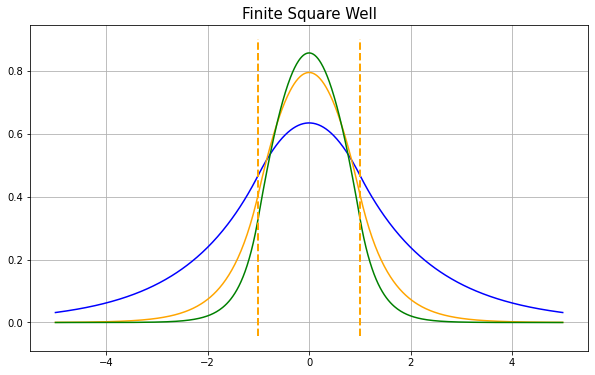

In [51]:
fig = plt.figure(figsize=(10,6))

plt.title('Finite Square Well', fontsize=15)

colors = ['blue','orange','green']

for clr, elmt in zip(colors, eqns):
    expx, cosx = elmt
    
    xseg1 = np.linspace(-5,-1, N)
    f1 = lambdify(x, expx)
    yval = f1(-xseg1)
    plt.plot(xseg1, yval, color=clr)
    
    xseg2 = np.linspace(1,5, N)
    yval = f1(xseg2)
    plt.plot(xseg2, yval, color=clr)
    
    f2 = lambdify(x, cosx)
    xseg3 = np.linspace(-1,1, N)
    yval = f2(xseg3)
    plt.plot(xseg3, yval, color=clr)
    
ymin, ymax = plt.gca().get_ylim()
xvlines = [-1, 1]
plt.vlines(xvlines, ymin, ymax, linestyle='dashed', color='orange', lw=2)
    
plt.grid()   

In [52]:
# The code under here is doubtful given the way it tries to calculate the energies and ends up
# with contradictory answers.
s = ""
for elmt in eqns:
    expx, cosx = elmt
    expxdiff = expx.diff(x,x)
    cosxdiff = cosx.diff(x,x)
    expr_exp = sym.solveset(sym.simplify((expx.diff(x,x)+2*m/hbar**2*(E-V0)*expx)/expx), E)
    cosx_exp = sym.solveset(sym.simplify((cosx.diff(x,x)+2*m/hbar**2*(E-V0)*cosx)/cosx), E)
    #display(Eq(E,expr_exp.args[0]), Eq(E, cosx_exp.args[0]))
    e1latex = (sym.latex(Eq(E,expr_exp.args[0])))
    e2latex = (sym.latex(Eq(E,cosx_exp.args[0])))
    s += "{} & {} ".format(e1latex, e2latex) 
    
    # use this to detect if at last index of for loop
    if elmt is not eqns[-1]:
        s += r" \\ "
    #display_latex ("$ "+e1latex+" $", raw=True)

    #display_latex('E = V_{0} - \\frac{0.226846595732537 \\hbar^{2}}{m}', raw=True)
s = r"$  \left \{ \begin{matrix} " + s + r"\end{matrix} \right \} $"

display_latex(s, raw=True)
